In [21]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import momepy

In [22]:
bike = gpd.read_file("./data/SDOT_Bike_Facilities_existing.geojson")
multi = gpd.read_file("./data/SDOT_Bike_Facilities_multiuse.geojson")
planned = gpd.read_file("./data/SDOT_Bike_Facilities_planned.geojson")
sBike = bike.to_crs('EPSG:32610')
sMulti = multi.to_crs('EPSG:32610')
sPlanned = planned.to_crs('EPSG:32610')

In [23]:
allBike = pd.concat([sBike, sMulti, sPlanned])
allBike = allBike.explode()

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_72197/2229002438.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  allBike = allBike.explode()


In [24]:
graph = momepy.gdf_to_nx(allBike, approach="primal", directed=True)

In [25]:
# Convert graph to gdf
nodes, edges = momepy.nx_to_gdf(graph)

In [26]:
# Provide an x and y for OSMnx
nodes['x'] = nodes['geometry'].x
nodes['y'] = nodes['geometry'].y

In [27]:
# Provide a u and v for OSMnx
edges['u'] = edges['node_start']
edges['v'] = edges['node_end']

In [28]:
# Make all roads "two-way"
opposite_direction = edges.copy()
opposite_direction = opposite_direction.rename(columns={"u": "v", "v": "u"})
directed_edges = pd.concat([edges, opposite_direction], ignore_index=True)

In [29]:
edges = directed_edges.set_index(['u', 'v'])

In [30]:
# Add a key index
doubles = edges[edges.index.duplicated()].copy()
singles = edges[~edges.index.duplicated()].copy()

singles['key'] = 0
doubles['key'] = 1

edges = pd.concat([singles, doubles])

In [31]:
# Make the multi-index
edges = edges.reset_index().set_index(['u', 'v', 'key'])

In [32]:
# Rename some columns
edges = edges[['UNITDESC','mm_len', 'geometry']]
edges = edges.rename(columns={"UNITDESC": "streets", "mm_len": "length"})

In [33]:
# Convery back to graph
gdf = ox.graph_from_gdfs(nodes, edges)

In [34]:
# Save and load
ox.save_graphml(gdf, './data/Sgraph_planned.graphml')
graph = ox.load_graphml('./data/Sgraph_planned.graphml')

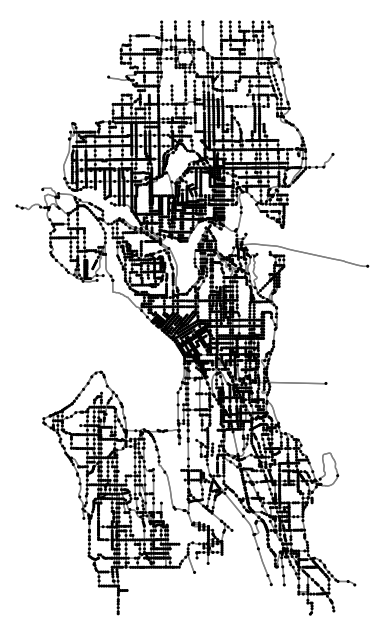

In [35]:
# Plot
fig, ax = ox.plot_graph(graph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)